# Unidirectional SPP from non-Hermitian metagratings

Non-Hermitian systems are open systems that can exchange energy, matter, or information with their surroundings through the engineering of gain or loss materials. While quantum mechanics traditionally requires Hamiltonians to be Hermitian to produce real eigenvalues, it's been discovered that a system with a spatially varying complex potential energy can still have real eigenvalues if it obeys a certain symmetry known as Parity-Time (PT) symmetry.

One concept that has gained particular attention in non-Hermitian photonics is the phenomenon of "exceptional points." These are points in parameter space at which the eigenvalues and the eigenvectors of a non-Hermitian system coincide. Around these exceptional points, systems can have unique and often counterintuitive properties. For instance, light in these systems can exhibit uni-directional propagation, enhanced sensitivity to external parameters, or unusual scattering behavior. Non-Hermitian photonics has potential applications in many areas, including the design of new types of lasers, sensors, and photonic devices with novel properties. 

This notebook demonstrates the unidirectional surface plasmon polariton (SPP) propagation from non-Hermitian metagratings. The design is adapted from [Yihao Xu et al. ,Subwavelength control of light transport at the exceptional point by non-Hermitian metagratings. Sci.  Adv. 9, eadf3510(2023)](https://www.science.org/doi/10.1126/sciadv.adf3510).

<img src="img/nonhermitian_metagrating.png" width="500">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.dispersion import DispersionFitter

## Simulation Setup 

Define the basic model parameters including the simulation wavelength/frequency and the metagrating geometric parameters.

In [2]:
lda0 = 1.15 # simulation wavelength
freq0 = td.C_0/lda0 # simulation frequency

w1 = 0.083 # width of the first nanostrip in the unit cell
w2 = 0.162 # width of the second nanostrip in the unit cell
t1 = 0.08  # thickness of the first nanostrip
t2 = 0.03  # thickness of the bottom layer of the second nanostrip
t3 = 0.022 # thickness of the top layer of the second nanostrip
s = 0.35  # center-to-center distance between the nanostrips
p = 1.14  # grating period
t_au = 0.06  # gold layer thickness
N = 9  # number of unit cells
inf_eff = 1e3 # effective infinity

The metagrating utilizes four materials: a silicon dioxide substrate, a gold thin film, germanium nanostrips, and chromium nanostrips. These materials can be defined in different ways. Specifically, we use the gold medium directly from the [material library](../material_library.html). The germanium is defined using the [from_nk](../_autosummary/tidy3d.Medium.html#tidy3d.Medium.from_nk) method by specifying the real and imaginary parts of the refractive index at the simulation frequency. Silicon dioxide is considered as a lossless medium. Chromium is modeled as a dispersive medium by fitting the raw data from experimental measurements. 

In this simulation, we are only concerned about one frequency, so in principle the dispersive fitting is not necessary. However, chromium has $Re(\varepsilon)<1$ at 1150 nm. In Tidy3D, we require the nondispersive medium to have $Re(\varepsilon)\ge 1$. Therefore, it can not be defined using the [from_nk](../_autosummary/tidy3d.Medium.html#tidy3d.Medium.from_nk) method directly and dispersive fitting is the only option. 

The raw data file `Cr_Sytchkova.csv` can be found on the refractive index [database](https://refractiveindex.info/?shelf=main&book=Cr&page=Sytchkova) or on our github [repo](https://github.com/flexcompute-readthedocs/tidy3d-docs/tree/latest/docs/source/notebooks/misc).

In [3]:
# define gold medium
Au = td.material_library['Au']['Olmon2012stripped']  

# define Ge medium
Ge = td.Medium.from_nk(n=4.6403, k=0.2519, freq=freq0)

# define SiO2 medium
SiO2 = td.Medium(permittivity=1.45**2)

# define Cr medium
fname = "misc/Cr_Sytchkova.csv"  # read the refractive index data from a csv file
fitter = DispersionFitter.from_file(fname, delimiter=",")  # construct a fitter
Cr, rms_error = fitter.fit(num_poles=4, num_tries=10)
fitted_nk = Cr.nk_model(freq0)


Output()

[09:04:13] WARNING:        warning: did not find fit with RMS error under tolerance_rms of 1.00e-02      ]8;id=332971;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\plugins\dispersion\fit.py\fit.py]8;;\:]8;id=555996;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\plugins\dispersion\fit.py#366\366]8;;\

After the fitting, we see a warning that the fitting RMS error didn't get lower than the threshold. We can inspect the fitting result of chromium to see if the fitting is sufficiently good. Here we do see the fitting is quite resonable.  

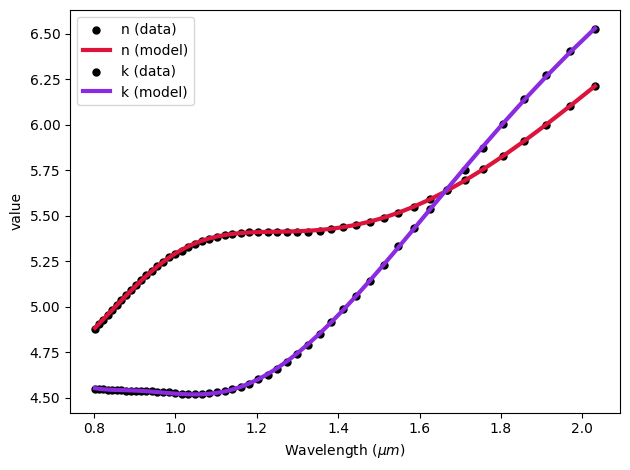

In [4]:
fitter.plot(Cr)
plt.show()

Next, we define the metagrating structures. The `N` unit cells can be defined by using a simple for loop.

In [5]:
# define the nanostrips that make up the unit cells
grating = []
for i in range(N):
    geo = td.Box(center=(-s/2+i*p-(N-1)*p/2, 0, t1/2), size=(w1,td.inf,t1))
    grating.append(td.Structure(geometry=geo, medium=Ge))
    
    geo = td.Box(center=(s/2+i*p-(N-1)*p/2, 0, t2/2), size=(w1,td.inf,t2))
    grating.append(td.Structure(geometry=geo, medium=Ge))
    
    geo = td.Box(center=(s/2+i*p-(N-1)*p/2, 0, t2+t3/2), size=(w1,td.inf,t3))
    grating.append(td.Structure(geometry=geo, medium=Cr))
    
# define the substrate
substrate_geo = td.Box.from_bounds(rmin=(-inf_eff,-inf_eff,-inf_eff), rmax=(inf_eff,inf_eff,-t_au))
substrate = td.Structure(geometry=substrate_geo, medium=SiO2)

# define the gold film
gold_film_geo = td.Box(center=(0,0,-t_au/2), size=(inf_eff, inf_eff, t_au))
gold_film = td.Structure(geometry=gold_film_geo, medium=Au)

For excitation, we define a [GaussianBeam](../_autosummary/tidy3d.GaussianBeam.html) incident on the metagrating. The `waist_radius` is set to five grating periods to ensure the entire grating array is covered by the beam. 

To visualize the SPP propagation, a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) is defined. Two [FluxMonitors](../_autosummary/tidy3d.FluxMonitor.html) are defined to measure the power transmissions of the SPP to the left and right. 

In [6]:
gaussian_beam = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    center=(0, 0, 5*lda0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0/10),
    direction="-",
    waist_radius=5*p,
)

field_monitor = td.FieldMonitor(
    size=(td.inf, 0, td.inf), 
    freqs=[freq0], 
    interval_space=(2,1,2),
    name="field"
)

flux_monitor_right = td.FluxMonitor(
    center=(23*p,0,0),
    size=(0, td.inf, 2*lda0),
    freqs=[freq0],
    name="flux_right",
)

flux_monitor_left = td.FluxMonitor(
    center=(-23*p,0,0),
    size=(0, td.inf, 2*lda0),
    freqs=[freq0],
    name="flux_left",
)

Define the Tidy3D [Simulation](../_autosummary/tidy3d.Simulation.html). The simulation is 2D so periodic boundary condition is applied to the direction with zero size (the $y$ direction in this case).

In [7]:
# simulation domain size
Lx = 50*p
Ly = 0
Lz = 7*lda0

# simulation run time
run_time = 5e-13

# define simulation
sim = td.Simulation(
        center=(0, 0, 2*lda0),
        size=(Lx, Ly, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
        structures=grating + [substrate, gold_film],
        sources=[gaussian_beam],
        monitors=[field_monitor, flux_monitor_right, flux_monitor_left],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(), y=td.Boundary.periodic(), z=td.Boundary.pml()
        ),  
)


Visualize the simulation setup.

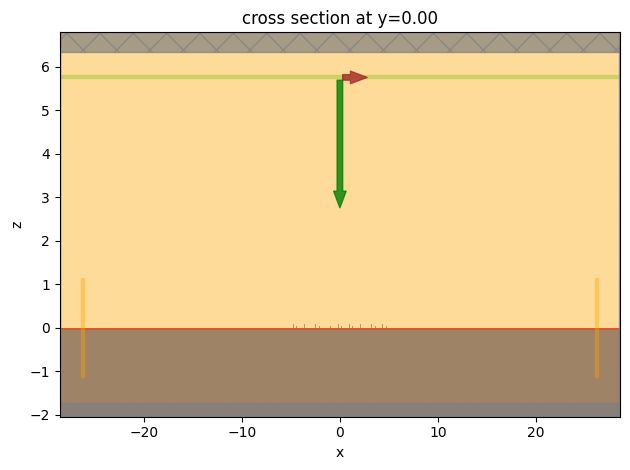

In [8]:
ax = sim.plot(y=0)
ax.set_aspect('auto')
plt.show()

Since the grating structures are small compared to the simulation domain, we can zoom in to see them more clearly.

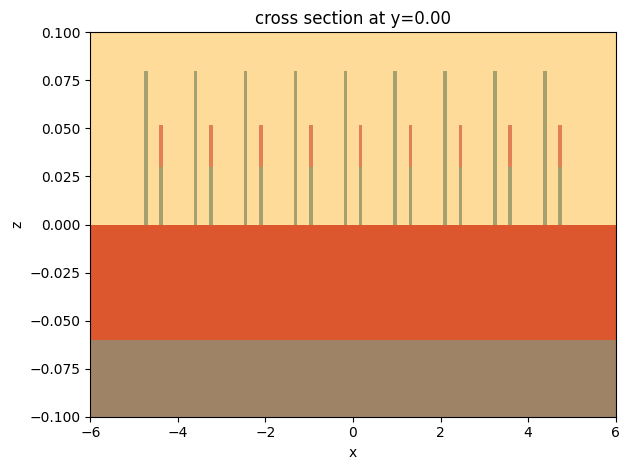

In [9]:
ax = sim.plot(y=0)
ax.set_xlim(-6, 6)
ax.set_ylim(-0.1, 0.1)
ax.set_aspect('auto')
plt.show()

The simulation settings look correct. We are ready to submit the simulation to the server.

In [10]:
sim_data = web.run(
    sim, task_name="nonhermitian_metagrating", path="data/simulation_data.hdf5"
)


[09:04:15] Created task 'nonhermitian_metagrating' with task_id                                       ]8;id=587613;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=183479;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\
           'fdve-1b904c01-a137-4d61-919d-5edb22c69867v1'.                                                          

           View task using web UI at                                                                  ]8;id=981672;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=302776;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=399223;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1b904c01-a137-4d61-919d-5edb22c69867v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=776300;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1b904c01-a137-4d61-919d-5edb22c69867v1\taskId]8;;\]8;id=399223;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1b904c01-a137-4d61-919d-5edb22c69867v1\=]8;;\]8;id=444537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1b904c01-a137-4d61-919d-5edb22c69867v1\fdve]8;;\]8;id=399223;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1b904c01-a137-4d61-919d-5edb22c69867v1\-1b904c01-a137-4d61-919d-5edb22c6986]8;;\              
           ]8;id=399223;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1b904c01-a137-4d61-919d-5edb22c69867v1\7v1']8;;\.                                                                                                   

Output()

[09:04:18] status = queued                                                                            ]8;id=754693;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=633125;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#321\321]8;;\

Output()

[09:04:20] status = preprocess                                                                        ]8;id=256187;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=709013;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#315\315]8;;\

[09:04:27] Maximum FlexCredit cost: 0.054. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=513457;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=133160;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=4196;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=95650;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=290089;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=996017;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#352\352]8;;\

Output()

[09:04:46] early shutoff detected, exiting.                                                           ]8;id=500916;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=83926;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=547837;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=362340;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#383\383]8;;\

Output()

[09:05:01] status = success                                                                           ]8;id=408992;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=690020;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\

Output()

[09:05:04] loading SimulationData from data/simulation_data.hdf5                                      ]8;id=612149;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=424210;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

## Result Analysis

Plot $|H_y|^2$ to visualize the SPP propagation. We can see the SPP is only propagating to the right, i.e. unidirectional propagation.

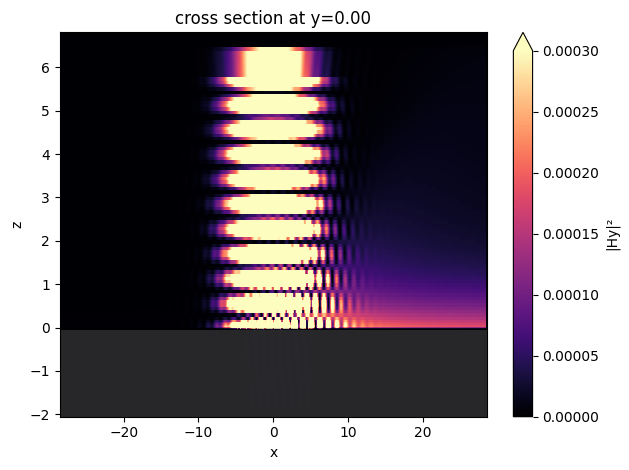

In [11]:
ax = sim_data.plot_field(field_monitor_name='field', field_name='Hy', val='abs^2', vmin=0, vmax=3e-4)
ax.set_aspect('auto')

To quantify the directionality, we define a contrast parameter $C_{exc} = \frac{I_r-I_l}{I_r+I_l}$, where $I_r$ and $I_l$ are the transmitted power to the right and to the left, respectively. $C_{exc}=0$ corresponds to an isotropic propagation. For the ideal unidirectional propagation, $C_{exc}=1$ or $C_{exc}=-1$. In this case, we observe $C_{exc}>0.98$.

In [12]:
def cal_C_exc(sim_data):
    I_r = sim_data['flux_right'].flux
    I_l = -sim_data['flux_left'].flux
    C_exc = (I_r-I_l)/(I_r+I_l)
    return C_exc.values[0]

print(f'C_exc = {cal_C_exc(sim_data):1.4f}')

C_exc = 0.9816


## Sweeping Nanostrip Spacing 

The SPP propagating can be effectively tuned by changing the center-to-center distance between the nanostrips within the grating unit cell. We would like to perform a parameter sweep of the center-to-center distance $s$ to investigate how the unidirectional SPP propagation changes. To do so, we first define a function `make_sim` that returns a simulation given a $s$ value.

In [13]:
def make_sim(s):
    
    # define the grating structures of each unit cell
    grating = []
    for i in range(N):
        geo = td.Box(center=(-s/2+i*p-(N-1)*p/2, 0, t1/2), size=(w1,td.inf,t1))
        grating.append(td.Structure(geometry=geo, medium=Ge))

        geo = td.Box(center=(s/2+i*p-(N-1)*p/2, 0, t2/2), size=(w1,td.inf,t2))
        grating.append(td.Structure(geometry=geo, medium=Ge))

        geo = td.Box(center=(s/2+i*p-(N-1)*p/2, 0, t2+t3/2), size=(w1,td.inf,t3))
        grating.append(td.Structure(geometry=geo, medium=Cr))

    # define simulation
    sim = td.Simulation(
        center=(0, 0, 2*lda0),
        size=(Lx, Ly, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
        structures=grating + [substrate, gold_film],
        sources=[gaussian_beam],
        monitors=[field_monitor, flux_monitor_right, flux_monitor_left],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.pml(), y=td.Boundary.periodic(), z=td.Boundary.pml()
        ),  
    )
    
    return sim

The range of interest for $s$ is from 350 nm to 770 nm. A batch of 5 simulations is created.

In [14]:
s_array = np.linspace(0.35,0.77,5)  # collection of s for the parameter sweep

sims = {
    f"s={s:.3f}": make_sim(s) for s in s_array
}  # construct simulations for each s from s_array


Run the simulations in the batch in parallel.

In [15]:
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data")

[09:05:10] Created task 's=0.350' with task_id 'fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1'.         ]8;id=374822;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=676061;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=780808;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=476025;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=497828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=111162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1\taskId]8;;\]8;id=497828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1\=]8;;\]8;id=895623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1\fdve]8;;\]8;id=497828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1\-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7]8;;\              
           ]8;id=497828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1\ev1']8;;\.                                                                                                   

Output()

[09:05:11] Created task 's=0.455' with task_id 'fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1'.         ]8;id=337055;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=590551;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=791494;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=18397;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=217224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=10657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1\taskId]8;;\]8;id=217224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1\=]8;;\]8;id=239651;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1\fdve]8;;\]8;id=217224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1\-7dbdb0a0-ea28-48cc-890a-da6b14fa24d]8;;\              
           ]8;id=217224;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1\6v1']8;;\.                                                                                                   

Output()

[09:05:12] Created task 's=0.560' with task_id 'fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1'.         ]8;id=274025;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=261058;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=126195;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=453545;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=341421;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=166330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1\taskId]8;;\]8;id=341421;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1\=]8;;\]8;id=510257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1\fdve]8;;\]8;id=341421;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1\-e8dea993-8d76-4b58-9e29-c41b208b012]8;;\              
           ]8;id=341421;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1\8v1']8;;\.                                                                                                   

Output()

[09:05:14] Created task 's=0.665' with task_id 'fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1'.         ]8;id=665915;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=709898;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=50425;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=247726;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=825818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=975261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1\taskId]8;;\]8;id=825818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1\=]8;;\]8;id=398595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1\fdve]8;;\]8;id=825818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1\-afc2f30d-c44b-414f-9d97-7fe201b33c1]8;;\              
           ]8;id=825818;https://tidy3d.simulation.cloud/workbench?taskId=fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1\1v1']8;;\.                                                                                                   

Output()

[09:05:15] Created task 's=0.770' with task_id 'fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1'.         ]8;id=584289;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=15337;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=278082;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=686765;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#188\188]8;;\
           ]8;id=974979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=412497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1\taskId]8;;\]8;id=974979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1\=]8;;\]8;id=561401;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1\fdve]8;;\]8;id=974979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1\-f85f5cf6-c637-41da-97ca-bead16181b9]8;;\              
           ]8;id=974979;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1\7v1']8;;\.                                                                                                   

Output()

[09:05:19] Started working on Batch.                                                               ]8;id=532397;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=336048;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#457\457]8;;\

Output()

[09:06:16] Batch complete.                                                                         ]8;id=949630;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=213069;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#497\497]8;;\

Plot $|H_y|^2$ for each simulation. We can see that the SPP propagates to the right for smaller $s$ and to the left for larger $s$.

$C_{exc}$ is also computed for each simulation.

Output()

[09:06:20] loading SimulationData from data\fdve-0bd55da1-3c1a-4ade-abdf-59b93e6ccc7ev1.hdf5          ]8;id=223348;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=849367;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Output()

[09:06:23] loading SimulationData from data\fdve-7dbdb0a0-ea28-48cc-890a-da6b14fa24d6v1.hdf5          ]8;id=218768;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=924549;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Output()

[09:06:37] loading SimulationData from data\fdve-e8dea993-8d76-4b58-9e29-c41b208b0128v1.hdf5          ]8;id=295287;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=790684;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Output()

[09:06:39] loading SimulationData from data\fdve-afc2f30d-c44b-414f-9d97-7fe201b33c11v1.hdf5          ]8;id=736049;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=320539;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

Output()

[09:06:42] loading SimulationData from data\fdve-f85f5cf6-c637-41da-97ca-bead16181b97v1.hdf5          ]8;id=780720;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=966591;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#568\568]8;;\

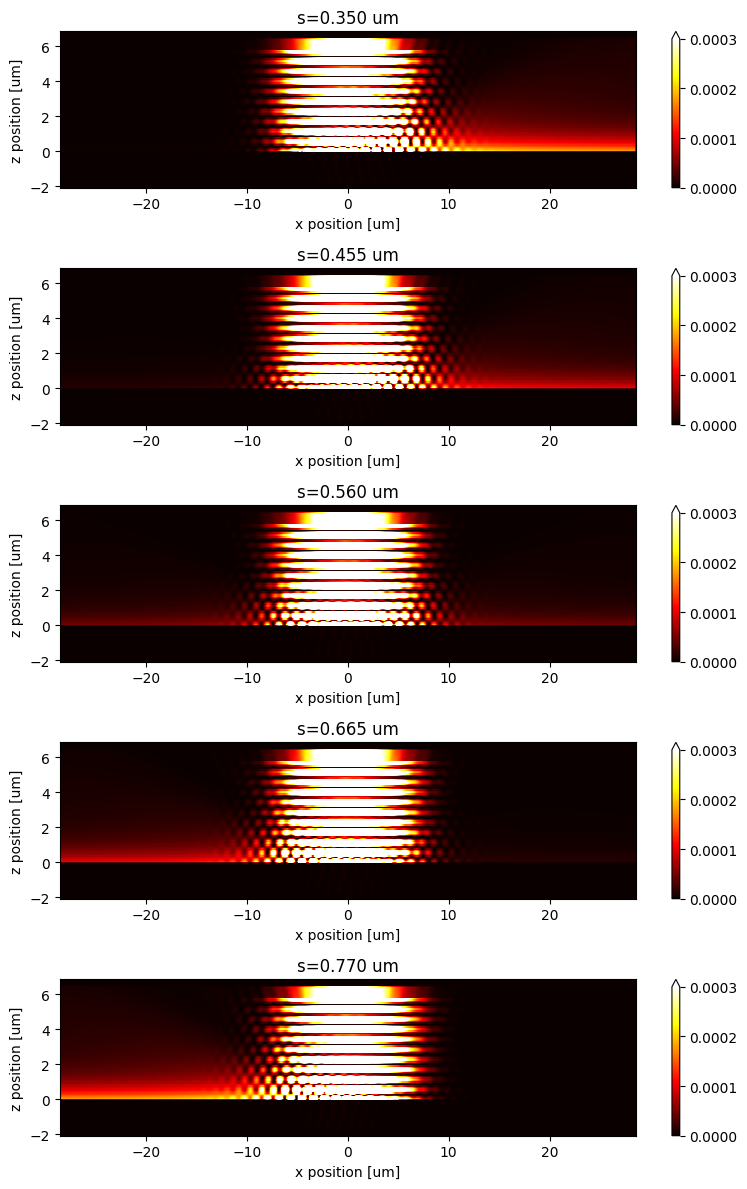

In [16]:
fig, ax = plt.subplots(len(s_array),1, tight_layout=True, figsize=(8,12))

C_exc = []

# computer |H_y|^2 and C_exc for each simulation
for i, s in enumerate(s_array):
    sim_data = batch_results[f"s={s:.3f}"]
    Hy_abs = sim_data['field'].Hy.abs
    Hy_squared = Hy_abs**2
    Hy_squared.plot(x='x',y='z',ax=ax[i], vmin=0, vmax=3e-4, cmap='hot')
    ax[i].set_title(f's={s:.3f} um')
    C_exc.append(cal_C_exc(sim_data))
    

Plot $C_{exc}$ as a function of $s$. $C_{exc}$ can be tuned from >0.98 to <-0.98 by changing $s$. Compared to the [original paper](https://www.science.org/doi/10.1126/sciadv.adf3510), the result here is slightly different, which we attribute to slightly different material properties used. 

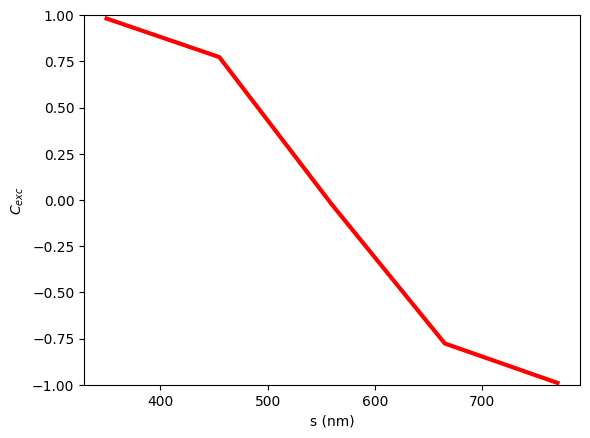

In [17]:
plt.plot(s_array*1e3, np.array(C_exc), c='red', linewidth=3)
plt.xlabel('s (nm)')
plt.ylabel('$C_{exc}$')
plt.ylim(-1,1)
plt.show()